In [1]:
%load_ext autoreload
%autoreload 3

In [20]:
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt

from cnaster_rs import CnasterGraph
from cnaster_rs import (
    get_triangular_lattice,
    get_slices_triangular_lattice_edges,
    nearest_neighbor_edges,
)
from cnaster.field import planar_power_law_fields
from cnaster.plotting import plot_cnaster_graph

In [3]:
ground_sites = get_triangular_lattice(10, 10, 0.0)
first_sites = get_triangular_lattice(20, 20, 2.5, x0=(-2.5, -2.5))

sites = np.vstack([ground_sites, first_sites])
sites[:10, :]

array([[0., 0., 0.],
       [1., 0., 0.],
       [2., 0., 0.],
       [3., 0., 0.],
       [4., 0., 0.],
       [5., 0., 0.],
       [6., 0., 0.],
       [7., 0., 0.],
       [8., 0., 0.],
       [9., 0., 0.]])

In [4]:
nxys = np.array([[10, 10], [20, 20]], dtype=np.uint64)

edges = get_slices_triangular_lattice_edges([ground_sites, first_sites], nxys)
edges

array([[  0,   1],
       [  0,  10],
       [  1,   2],
       ...,
       [498, 479],
       [499, 498],
       [499, 479]], dtype=uint64)

In [5]:
alignment_edges, alignment_weights = nearest_neighbor_edges(
    [ground_sites, first_sites], 4, max_distance=5.0
)
alignment_edges

array([[  0, 161],
       [  0, 141],
       [  0, 142],
       ...,
       [429,  99],
       [429,  98],
       [430,  99]], dtype=uint64)

In [6]:
# NB read and snp-read coverages (per spot?)
coverages = np.ones((len(sites), 2))

In [7]:
max_label = 3

graph = CnasterGraph(sites, coverages, max_label)
graph.update_adjacency_list(edges)
graph.update_adjacency_list(alignment_edges, alignment_weights)

graph

CnasterGraph(num_nodes=500, num_edges=4137, max_label=3, mean_coverage=[1.0, 1.0])

In [8]:
graph.max_edge_weight

4.99198086745911

In [9]:
graph.labels

array([3, 2, 3, 0, 2, 2, 1, 3, 0, 3, 1, 3, 3, 3, 0, 2, 1, 0, 2, 1, 1, 3,
       3, 0, 2, 1, 2, 3, 0, 1, 3, 1, 2, 0, 3, 1, 0, 0, 3, 3, 2, 1, 3, 2,
       3, 0, 0, 3, 1, 0, 1, 1, 1, 3, 1, 0, 0, 0, 1, 0, 3, 2, 0, 1, 2, 3,
       0, 1, 0, 3, 1, 2, 1, 2, 2, 0, 2, 2, 1, 3, 3, 2, 2, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 3, 2, 3, 0, 1, 1, 0, 0, 0, 1, 3, 0, 1, 0, 0, 2,
       2, 3, 3, 1, 0, 3, 2, 0, 0, 1, 2, 2, 2, 3, 2, 3, 2, 3, 3, 3, 2, 3,
       0, 2, 3, 0, 0, 1, 2, 2, 1, 3, 2, 0, 1, 1, 2, 1, 0, 0, 2, 2, 2, 3,
       1, 3, 3, 3, 1, 2, 1, 1, 1, 0, 3, 0, 0, 0, 2, 3, 2, 2, 2, 2, 2, 2,
       1, 2, 0, 0, 3, 0, 1, 0, 1, 0, 0, 3, 2, 0, 0, 2, 1, 0, 3, 1, 2, 3,
       1, 2, 0, 2, 0, 2, 2, 1, 3, 1, 3, 0, 1, 3, 2, 0, 0, 0, 1, 3, 0, 3,
       1, 2, 3, 3, 3, 1, 0, 3, 1, 2, 2, 3, 2, 0, 0, 3, 3, 0, 0, 3, 0, 1,
       2, 1, 1, 2, 1, 0, 1, 1, 0, 2, 0, 1, 2, 1, 3, 0, 2, 0, 3, 2, 1, 0,
       1, 3, 0, 0, 2, 0, 3, 3, 3, 3, 0, 2, 1, 1, 3, 3, 1, 1, 0, 1, 3, 3,
       0, 3, 3, 1, 2, 0, 3, 1, 2, 2, 1, 2, 2, 3, 1,

In [10]:
H = np.ones((graph.num_nodes, 1 + graph.max_label))
H

array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       ...,
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]])

In [11]:
cost, hcost = graph.potts_cost(1.0), graph.potts_cost(1.0, H)
cost, hcost

(3510.805214885884, 4010.805214885884)

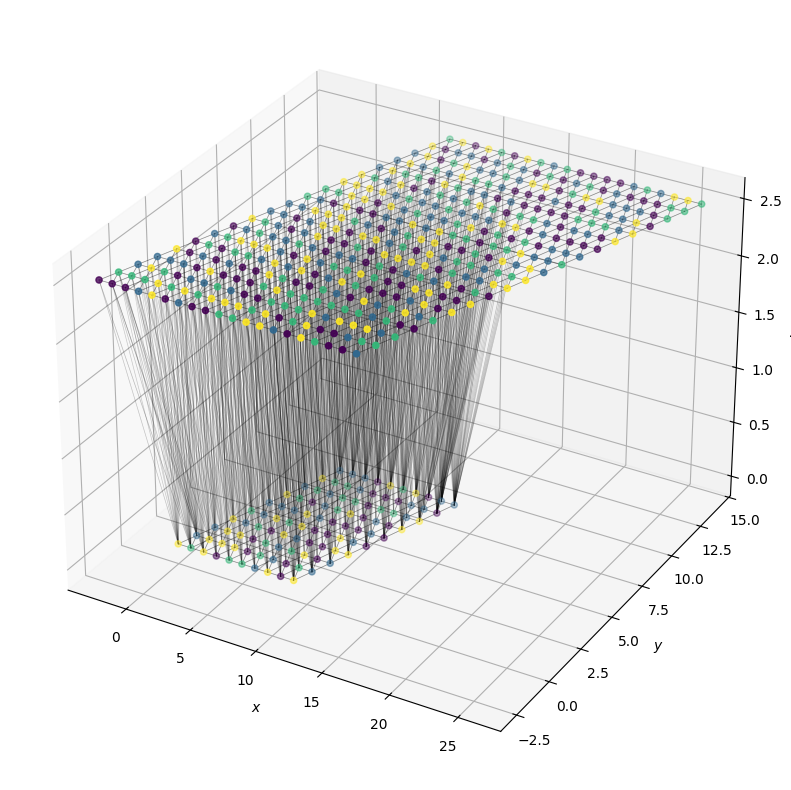

In [12]:
plot_cnaster_graph(graph)

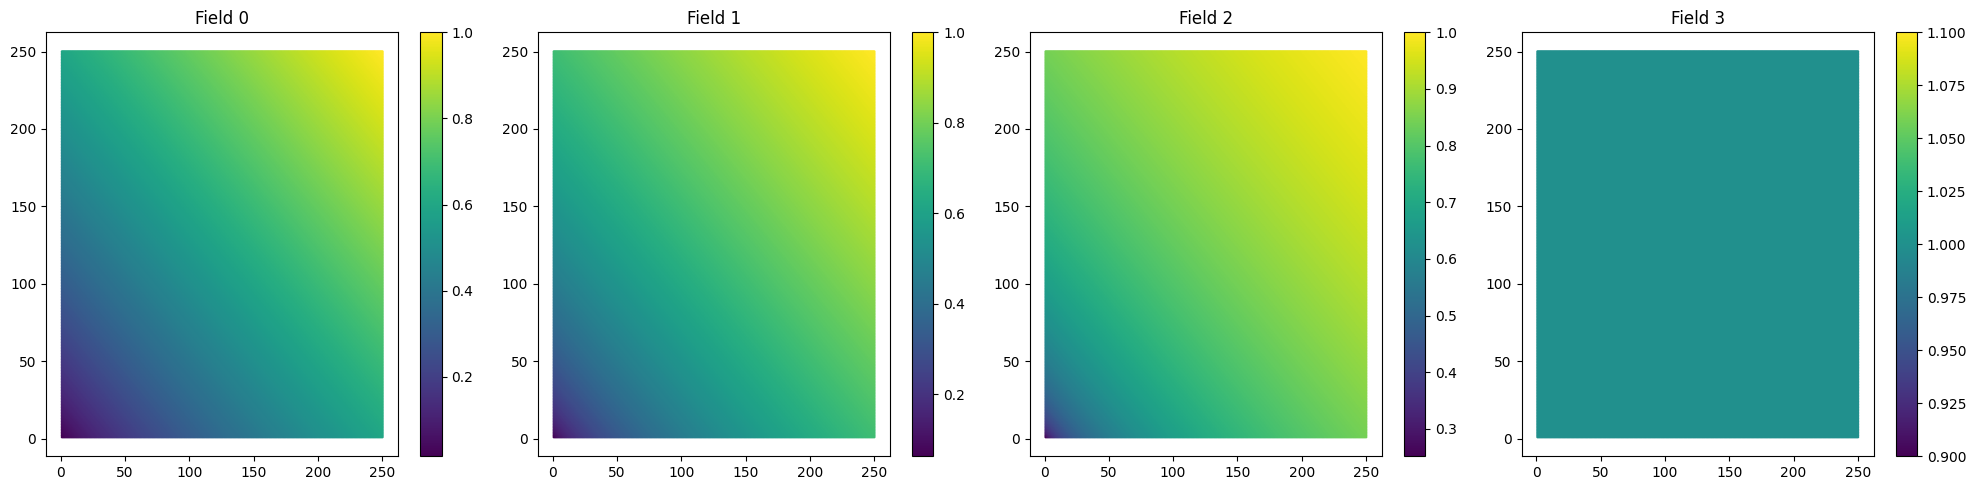

In [52]:
vec_k = np.array([1.0, 1.0])

N = 250
x, y = np.meshgrid(1 + np.arange(N), 1 + np.arange(N))
positions = np.stack([x.ravel(), y.ravel(), y.ravel()], axis=1)

fields = planar_power_law_fields(
    positions, graph.max_label, vec_k
)  # shape: (N*N, num_fields)

num_fields = fields.shape[1]
fig, axes = pl.subplots(1, num_fields, figsize=(5 * num_fields, 5), squeeze=False)

for i in range(num_fields):
    ax = axes[0, i]
    sc = ax.scatter(positions[:, 0], positions[:, 1], c=fields[:, i], s=1)
    ax.set_title(f"Field {i}")
    fig.colorbar(sc, ax=ax)

pl.tight_layout()
pl.show()

# Done.